In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import csv
import urllib.request
from scipy.special import softmax
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn

In [2]:
twts=pd.read_csv('Data/TweetSentiment.csv')
twts.head()

,tweet_id,ticker_symbol,post_date,body,comment_num,retweet_num,like_num,sentiment
0,550441509175443456,AAPL,2014-12-31,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,0.990795
1,550441672312512512,AAPL,2014-12-31,Insanity of today weirdo massive selling. $aap...,0,0,0,0.009752
2,550441732014223360,AMZN,2014-12-31,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,0.698949
3,550442977802207232,TSLA,2014-12-31,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,0.911501
4,550443807834402816,AAPL,2014-12-31,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,0.985529


In [3]:
twts=twts[['ticker_symbol','post_date','retweet_num','like_num','sentiment']]
twts.head()

,ticker_symbol,post_date,retweet_num,like_num,sentiment
0,AAPL,2014-12-31,0,1,0.990795
1,AAPL,2014-12-31,0,0,0.009752
2,AMZN,2014-12-31,0,0,0.698949
3,TSLA,2014-12-31,0,1,0.911501
4,AAPL,2014-12-31,0,1,0.985529


In [4]:
import math

def tweet_agreement_score(likes, retweets, w1=1, w2=2, s=10):
    x = (w1 * (likes+0.3) + w2 * (retweets+0.3)) / s
    tas = 1 / (1 + math.exp(-x))
    return tas


In [5]:
tas=[]
for i in range(len(twts['sentiment'])):
    tas.append(tweet_agreement_score(twts['like_num'][i],twts['retweet_num'][i],w1=1, w2=2, s=1))

twts['tas']=tas
twts.head()

,ticker_symbol,post_date,retweet_num,like_num,sentiment,tas
0,AAPL,2014-12-31,0,1,0.990795,0.869892
1,AAPL,2014-12-31,0,0,0.009752,0.710950
2,AMZN,2014-12-31,0,0,0.698949,0.710950
3,TSLA,2014-12-31,0,1,0.911501,0.869892
4,AAPL,2014-12-31,0,1,0.985529,0.869892


In [6]:
p=[]
for i in range(len(twts['sentiment'])):
    p.append(twts['sentiment'][i]*twts['tas'][i])


twts['p_sentiment']=p

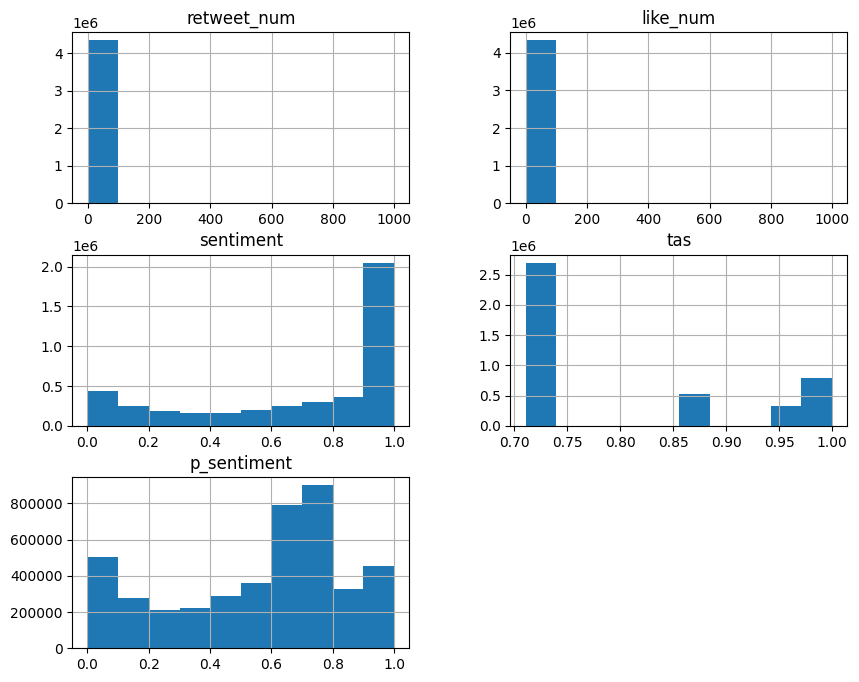

In [7]:
twts.hist(figsize=(10,8))
plt.show()

In [8]:
sum_twts = twts.groupby(['post_date', 'ticker_symbol']).agg({'p_sentiment': 'mean'}).reset_index()

sum_twts.head()

,post_date,ticker_symbol,p_sentiment
0,2014-12-31,AAPL,0.616032
1,2014-12-31,AMZN,0.380866
2,2014-12-31,GOOG,0.604001
3,2014-12-31,GOOGL,0.658132
4,2014-12-31,MSFT,0.616674


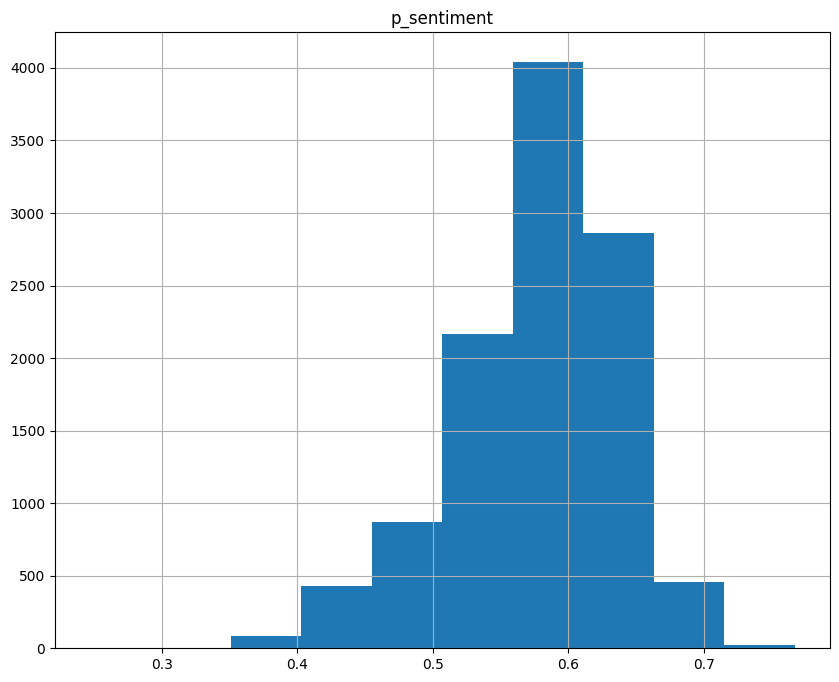

In [9]:
sum_twts.hist(figsize=(10,8))
plt.show()

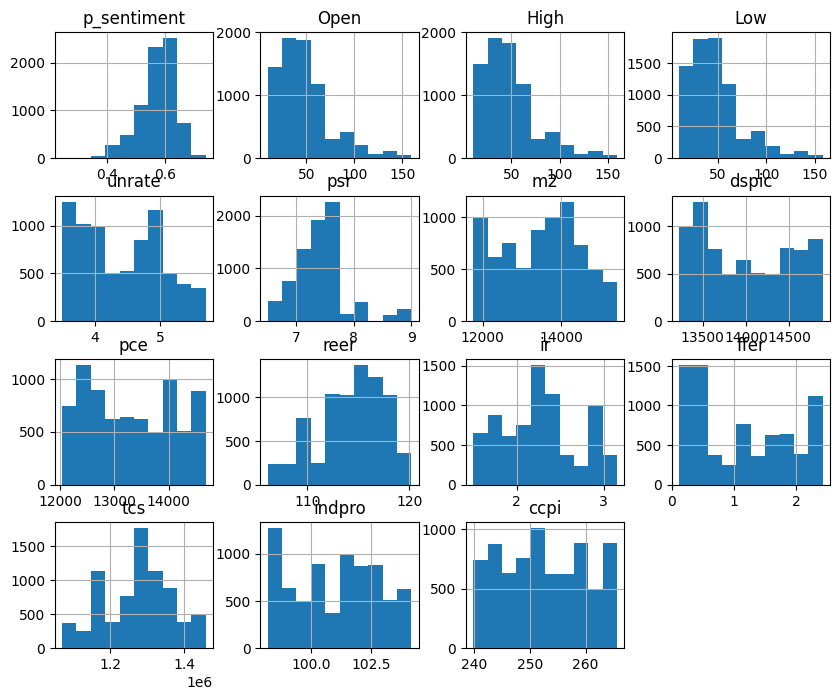

In [10]:
df=pd.read_csv('Data/Incomplete.csv')
sum_twts = sum_twts.rename(columns={'post_date': 'Date'})



merged = sum_twts.merge(df, on=['Date', 'ticker_symbol'], how='inner', indicator=False)
merged.hist(figsize=(10,8))
plt.show()

In [11]:
print(merged.columns)

Index(['Date', 'ticker_symbol', 'p_sentiment', 'Open', 'High', 'Low', 'unrate',
       'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer', 'tcs', 'indpro',
       'ccpi'],
      dtype='object')


In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [13]:
#generate one dataframe for each ticker symbol
tickers = merged['ticker_symbol'].unique()
dfs = []
for ticker in tickers:
    dfs.append(merged[merged['ticker_symbol'] == ticker])


In [14]:
for i in range(len(dfs)):
    print(dfs[i].head())

          Date ticker_symbol  p_sentiment       Open       High        Low  \
0   2015-01-02          AAPL     0.646878  27.847500  27.860001  26.837500   
6   2015-01-05          AAPL     0.582545  27.072500  27.162500  26.352501   
12  2015-01-06          AAPL     0.599274  26.635000  26.857500  26.157499   
18  2015-01-07          AAPL     0.609659  26.799999  27.049999  26.674999   
24  2015-01-08          AAPL     0.591898  27.307501  28.037500  27.174999   

    unrate  psr       m2    dspic      pce    reer      ir      ffer  \
0      5.7  8.0  11759.1  13224.7  12036.5  106.11  1.8815  0.114839   
6      5.7  8.0  11759.1  13224.7  12036.5  106.11  1.8815  0.114839   
12     5.7  8.0  11759.1  13224.7  12036.5  106.11  1.8815  0.114839   
18     5.7  8.0  11759.1  13224.7  12036.5  106.11  1.8815  0.114839   
24     5.7  8.0  11759.1  13224.7  12036.5  106.11  1.8815  0.114839   

          tcs    indpro     ccpi  
0   1069010.0  102.8479  239.811  
6   1069010.0  102.8479  239

In [15]:
from copy import deepcopy as dc
def dataframe2lstm(df,steps):
    df=dc(df)
    columns=['p_sentiment', 'Open', 'High', 'Low', 'unrate',
       'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer', 'tcs', 'indpro',
       'ccpi']
    df['Date']=pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    for i in range(1,steps+1):
        for col in columns:
            s=str(col+f' (t-{i})')
            df[s]=df[col].shift(i)
    
    df.dropna(inplace=True)

    return df

In [16]:
dfs_steps=[]
for df in dfs:
    dfs_steps.append(dataframe2lstm(df,5))

In [17]:
#put each dataframe into a dicktionary with the key being the ticker symbol and remove the ticker symbol column
data={}
for i in range(len(tickers)):
    data[tickers[i]]=dfs_steps[i].drop(columns=['ticker_symbol'])
    print(data[tickers[i]].head())



            p_sentiment     Open       High        Low  unrate  psr       m2  \
Date                                                                           
2015-01-09     0.657615  28.1675  28.312500  27.552500     5.7  8.0  11759.1   
2015-01-12     0.595788  28.1500  28.157499  27.200001     5.7  8.0  11759.1   
2015-01-13     0.557642  27.8575  28.200001  27.227501     5.7  8.0  11759.1   
2015-01-14     0.520694  27.2600  27.622499  27.125000     5.7  8.0  11759.1   
2015-01-15     0.515277  27.5000  27.514999  26.665001     5.7  8.0  11759.1   

              dspic      pce    reer  ...  psr (t-5)  m2 (t-5)  dspic (t-5)  \
Date                                  ...                                     
2015-01-09  13224.7  12036.5  106.11  ...        8.0   11759.1      13224.7   
2015-01-12  13224.7  12036.5  106.11  ...        8.0   11759.1      13224.7   
2015-01-13  13224.7  12036.5  106.11  ...        8.0   11759.1      13224.7   
2015-01-14  13224.7  12036.5  106.11  ...   

In [18]:
#df=pd.get_dummies(df, columns=['ticker_symbol'])
#df.iloc[:, -6:]=df.iloc[:, -6:].astype(int)

In [19]:
companies=list(data.keys())
companies

['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'MSFT', 'TSLA']

In [20]:
for ticker in data.keys():
    cols = data[ticker].columns.tolist()
    cols = cols[2:4] + cols[0:2] + cols[4:]
    data[ticker] = data[ticker][cols]
    print(data[ticker].head())

                 High        Low  p_sentiment     Open  unrate  psr       m2  \
Date                                                                           
2015-01-09  28.312500  27.552500     0.657615  28.1675     5.7  8.0  11759.1   
2015-01-12  28.157499  27.200001     0.595788  28.1500     5.7  8.0  11759.1   
2015-01-13  28.200001  27.227501     0.557642  27.8575     5.7  8.0  11759.1   
2015-01-14  27.622499  27.125000     0.520694  27.2600     5.7  8.0  11759.1   
2015-01-15  27.514999  26.665001     0.515277  27.5000     5.7  8.0  11759.1   

              dspic      pce    reer  ...  psr (t-5)  m2 (t-5)  dspic (t-5)  \
Date                                  ...                                     
2015-01-09  13224.7  12036.5  106.11  ...        8.0   11759.1      13224.7   
2015-01-12  13224.7  12036.5  106.11  ...        8.0   11759.1      13224.7   
2015-01-13  13224.7  12036.5  106.11  ...        8.0   11759.1      13224.7   
2015-01-14  13224.7  12036.5  106.11  ...   

In [21]:
Xs=[]
Ys=[]
for ticker in data.keys():
    x=(data[ticker].iloc[:,2:].values)
    Ys.append(data[ticker].iloc[:,1:3].values)
    x=np.flip(x,1)
    print(x.shape)
    Xs.append(x)

for i in Ys:
    print(i.shape)

(1247, 88)
(1252, 88)
(1251, 88)
(1252, 88)
(1252, 88)
(1252, 88)
(1247, 2)
(1252, 2)
(1251, 2)
(1252, 2)
(1252, 2)
(1252, 2)


In [22]:
#normalize x and y
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xn=[]
Yn=[]
for x in Xs:
    Xn.append(scaler.fit_transform(x))
for y in Ys:
    Yn.append(scaler.fit_transform(y))


for i in Xn:
    print(i.shape)
for i in Yn:
    print(i.shape)



(1247, 88)
(1252, 88)
(1251, 88)
(1252, 88)
(1252, 88)
(1252, 88)
(1247, 2)
(1252, 2)
(1251, 2)
(1252, 2)
(1252, 2)
(1252, 2)


In [23]:
#split into train, test and validation. using sklearn
from sklearn.model_selection import train_test_split
X_train=[]
X_test=[]
X_val=[]
Y_train=[]
Y_test=[]
Y_val=[]
for x in Xn:
    x_train, x_test, x_val = np.split(x, [int(.6*len(x)), int(.8*len(x))])
    X_train.append(x_train)
    X_test.append(x_test)
    X_val.append(x_val)
for y in Yn:
    y_train, y_test, y_val = np.split(y, [int(.6*len(y)), int(.8*len(y))])
    Y_train.append(y_train)
    Y_test.append(y_test)
    Y_val.append(y_val)



In [24]:
#reshape to add the time dimension
for i in range(len(X_train)):
    X_train[i]=X_train[i].reshape(X_train[i].shape[0],X_train[i].shape[1],1)
    X_test[i]=X_test[i].reshape(X_test[i].shape[0],X_test[i].shape[1],1)
    X_val[i]=X_val[i].reshape(X_val[i].shape[0],X_val[i].shape[1],1)

for i in range(len(X_train)):
    print(X_train[i].shape)
    print(X_test[i].shape)
    print(X_val[i].shape)
    print(Y_train[i].shape)
    print(Y_test[i].shape)
    print(Y_val[i].shape)  

(748, 88, 1)
(249, 88, 1)
(250, 88, 1)
(748, 2)
(249, 2)
(250, 2)
(751, 88, 1)
(250, 88, 1)
(251, 88, 1)
(751, 2)
(250, 2)
(251, 2)
(750, 88, 1)
(250, 88, 1)
(251, 88, 1)
(750, 2)
(250, 2)
(251, 2)
(751, 88, 1)
(250, 88, 1)
(251, 88, 1)
(751, 2)
(250, 2)
(251, 2)
(751, 88, 1)
(250, 88, 1)
(251, 88, 1)
(751, 2)
(250, 2)
(251, 2)
(751, 88, 1)
(250, 88, 1)
(251, 88, 1)
(751, 2)
(250, 2)
(251, 2)


In [25]:
#turn all the data into tensors
for i in range(len(X_train)):
    X_train[i]=torch.tensor(X_train[i],dtype=torch.float32)
    X_test[i]=torch.tensor(X_test[i],dtype=torch.float32)
    X_val[i]=torch.tensor(X_val[i],dtype=torch.float32)
    Y_train[i]=torch.tensor(Y_train[i],dtype=torch.float32)
    Y_test[i]=torch.tensor(Y_test[i],dtype=torch.float32)
    Y_val[i]=torch.tensor(Y_val[i],dtype=torch.float32)
    




In [26]:
#print tensor shapes
for i in range(len(X_train)):
    print(X_train[i].shape)
    print(X_test[i].shape)
    print(X_val[i].shape)
    print(Y_train[i].shape)
    print(Y_test[i].shape)
    print(Y_val[i].shape)

torch.Size([748, 88, 1])
torch.Size([249, 88, 1])
torch.Size([250, 88, 1])
torch.Size([748, 2])
torch.Size([249, 2])
torch.Size([250, 2])
torch.Size([751, 88, 1])
torch.Size([250, 88, 1])
torch.Size([251, 88, 1])
torch.Size([751, 2])
torch.Size([250, 2])
torch.Size([251, 2])
torch.Size([750, 88, 1])
torch.Size([250, 88, 1])
torch.Size([251, 88, 1])
torch.Size([750, 2])
torch.Size([250, 2])
torch.Size([251, 2])
torch.Size([751, 88, 1])
torch.Size([250, 88, 1])
torch.Size([251, 88, 1])
torch.Size([751, 2])
torch.Size([250, 2])
torch.Size([251, 2])
torch.Size([751, 88, 1])
torch.Size([250, 88, 1])
torch.Size([251, 88, 1])
torch.Size([751, 2])
torch.Size([250, 2])
torch.Size([251, 2])
torch.Size([751, 88, 1])
torch.Size([250, 88, 1])
torch.Size([251, 88, 1])
torch.Size([751, 2])
torch.Size([250, 2])
torch.Size([251, 2])


In [27]:
#generate time series datasets
from torch.utils.data import TensorDataset, DataLoader
train_data=[]
test_data=[]
val_data=[]
for i in range(len(X_train)):
    train_data.append(TensorDataset(X_train[i],Y_train[i]))
    test_data.append(TensorDataset(X_test[i],Y_test[i]))
    val_data.append(TensorDataset(X_val[i],Y_val[i]))




In [28]:
#data loader
batch_size=64
train_loader=[]
test_loader=[]
val_loader=[]
for i in range(len(X_train)):
    train_loader.append(DataLoader(train_data[i],batch_size=batch_size,shuffle=True))
    test_loader.append(DataLoader(test_data[i],batch_size=batch_size,shuffle=False))
    val_loader.append(DataLoader(val_data[i],batch_size=batch_size,shuffle=False))

In [29]:
#show batch shapes
for i in range(len(X_train)):
    for x,y in train_loader[i]:
        print(x.shape)
        print(y.shape)
        break
    for x,y in test_loader[i]:
        print(x.shape)
        print(y.shape)
        break
    for x,y in val_loader[i]:
        print(x.shape)
        print(y.shape)
        break


torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])
torch.Size([64, 88, 1])
torch.Size([64, 2])


In [30]:
#lstm model with 79 input features, 2 output features and 2 lstm layers
input_shape=X_test[i].shape[1]
class LSTM(nn.Module):
    def __init__(self, input_size=input_shape, output_size=2, hidden_dim=256, n_layers=4):
        super().__init__()
        self.hidden_dim=hidden_dim
        self.n_layers=n_layers
        self.lstm=nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc=nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        h0=torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0=torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn)=self.lstm(x, (h0.detach(), c0.detach()))
        out=self.fc(out[:, -1, :])
        return out


In [31]:
#a list of models, one for each ticker symbol
models=[]
for i in range(len(X_train)):
    models.append(LSTM().to(device))
    print(models[i])


LSTM(
  (lstm): LSTM(88, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(88, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(88, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(88, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(88, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(88, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Training for AAPL
epoch: 0, loss: 0.028633812442421913, val_loss: 0.29284489154815674
epoch: 1, loss: 0.021617496386170387, val_loss: 0.2413056194782257
epoch: 2, loss: 0.010862156748771667, val_loss: 0.20487844944000244
epoch: 3, loss: 0.016254454851150513, val_loss: 0.21823778748512268
epoch: 4, loss: 0.008464189246296883, val_loss: 0.20272958278656006
epoch: 5, loss: 0.007929570972919464, val_loss: 0.21522843837738037
epoch: 6, loss: 0.009569024667143822, val_loss: 0.1862628161907196
epoch: 7, loss: 0.007998684421181679, val_loss: 0.18604712188243866
epoch: 8, loss: 0.008236804977059364, val_loss: 0.1781691461801529
epoch: 9, loss: 0.0072001926600933075, val_loss: 0.16420820355415344
epoch: 10, loss: 0.0058219642378389835, val_loss: 0.14221127331256866
epoch: 11, loss: 0.006997532676905394, val_loss: 0.10140938311815262
epoch: 12, loss: 0.004782675299793482, val_loss: 0.06941564381122589
epoch: 13, loss: 0.0031297546811401844, val_loss: 0.055167824029922485
epoch: 14, loss: 0.003957

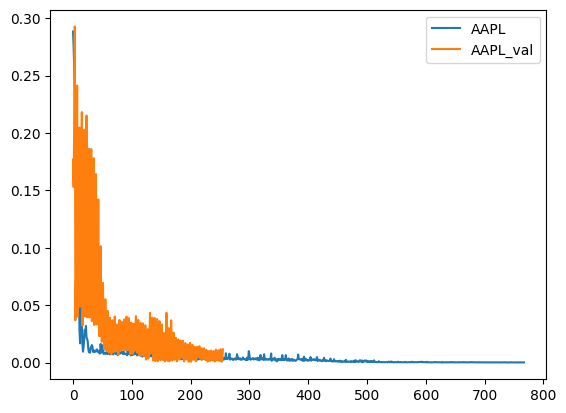

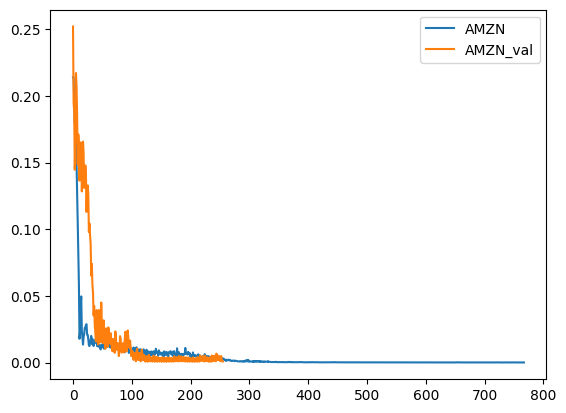

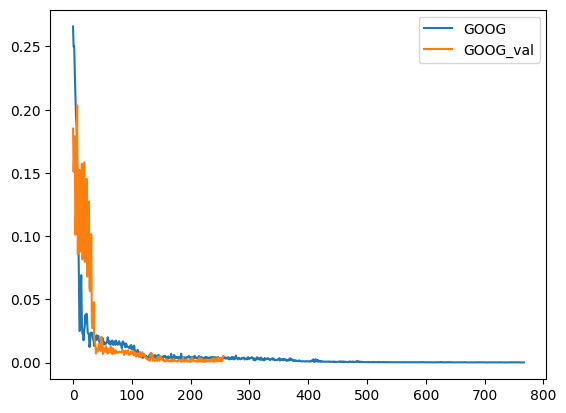

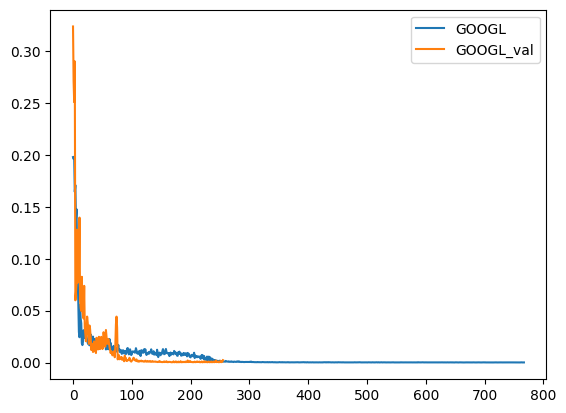

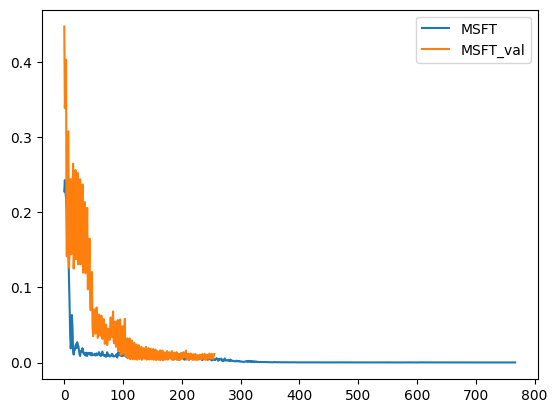

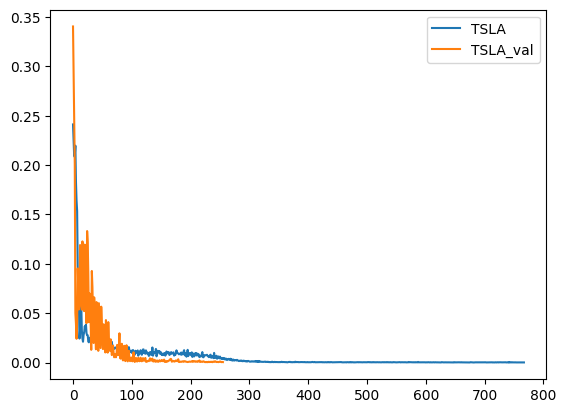

In [33]:


#training loop and parameters
criterion=nn.MSELoss()
optimizer=[]
for i in range(len(models)):
    optimizer.append(torch.optim.Adam(models[i].parameters(), lr=0.001))

epochs=64
losses=[]
val_losses=[]
for i in range(len(train_loader)):
    los=[]
    val_los=[]
    print(f'Training for {companies[i]}')
    for epoch in range(epochs):
        for _, batch in enumerate(train_loader[i]):
            x_batch, y_batch=batch[0].to(device), batch[1].to(device)
            # reshape the input tensor to have the correct size
            x_batch = x_batch.view(x_batch.shape[0], -1, input_shape)
            optimizer[i].zero_grad()
            output=models[i](x_batch)
            loss=criterion(output, y_batch)
            loss.backward()
            optimizer[i].step()
            los.append(loss.item())
        
        with torch.no_grad():
            for _, batch in enumerate(val_loader[i]):
                x_batch, y_batch=batch[0].to(device), batch[1].to(device)
                # reshape the input tensor to have the correct size
                x_batch = x_batch.view(x_batch.shape[0], -1, input_shape)
                output=models[i](x_batch)
                val_loss=criterion(output, y_batch)
                val_los.append(val_loss.item())
            
            # print the loss and validation loss for each epoch
            print(f'epoch: {epoch}, loss: {loss.item()}, val_loss: {val_loss.item()}')
    losses.append(los)
    val_losses.append(val_los)
    

# plot the training and validation losses individualy
for i in range(len(losses)):
    plt.plot(losses[i], label=f'{companies[i]}')
    plt.plot(val_losses[i], label=f'{companies[i]}_val')
    plt.legend()
    plt.show()

In [34]:
len(val_losses[0])

256

In [35]:
#evaluate the models with the test data by metrics: mae, rmse, mse and r2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
maes=[]
rmses=[]
mses=[]
r2s=[]

for i in range(len(test_loader)):
    with torch.no_grad():
        for _, batch in enumerate(test_loader[i]):
            x_batch, y_batch=batch[0].to(device), batch[1].to(device)
            # reshape the input tensor to have the correct size
            x_batch = x_batch.view(x_batch.shape[0], -1, input_shape)
            output=models[i](x_batch)
            mae=mean_absolute_error(y_batch.cpu(), output.cpu())
            mse=mean_squared_error(y_batch.cpu(), output.cpu())
            rmse=np.sqrt(mse)
            r2=r2_score(y_batch.cpu(), output.cpu())
            maes.append(mae)
            rmses.append(rmse)
            mses.append(mse)
            r2s.append(r2)
            print(f'mae: {mae}, rmse: {rmse}, mse: {mse}, r2: {r2}')

mae: 0.019222956150770187, rmse: 0.02520725317299366, mse: 0.0006354056531563401, r2: 0.5224834042891335
mae: 0.017292750999331474, rmse: 0.02094247378408909, mse: 0.0004385871870908886, r2: 0.8522014019373425
mae: 0.02219356596469879, rmse: 0.0288567915558815, mse: 0.0008327143732458353, r2: 0.8032453312471077
mae: 0.03428884223103523, rmse: 0.04142170399427414, mse: 0.0017157576512545347, r2: 0.8502843378521718
mae: 0.018915798515081406, rmse: 0.03169778734445572, mse: 0.0010047497926279902, r2: 0.9067441980303975
mae: 0.02027871459722519, rmse: 0.03015553578734398, mse: 0.0009093563421629369, r2: 0.8944131117557632
mae: 0.037160322070121765, rmse: 0.04810516908764839, mse: 0.002314107259735465, r2: 0.6481378688562884
mae: 0.05664839595556259, rmse: 0.0687197595834732, mse: 0.0047224052250385284, r2: 0.5961137597956153
mae: 0.024577997624874115, rmse: 0.030639607459306717, mse: 0.000938785495236516, r2: 0.7633396526817918
mae: 0.025791872292757034, rmse: 0.032747820019721985, mse: 0.

In [36]:
#evaluate the models with the test data by metrics: mape, smape, mbd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
def mape(y_true, y_pred):
    sum=0
    frac=100/len(y_true)
    for i in range(len(y_true)):
        sum=(abs(y_true[i]-y_pred[i])/y_true[i])+sum
    return frac*sum

def smape(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))))*200
def mbd(y_true, y_pred):
    return np.mean(np.sum((y_pred - y_true) / y_true))*100

#evaluate the models with the test data by metrics: mape, smape, mbd

for i in range(len(test_loader)):
    for x,y in test_loader[i]:
        x_batch, y_batch=x.to(device), y.to(device)
        # reshape the input tensor to have the correct size
        x_batch = x_batch.view(x_batch.shape[0], -1, input_shape)
        output=models[i](x_batch)
        #unnormalize the output
        #output=scaler.inverse_transform(output.cpu().detach().numpy())
        #y_batch=scaler.inverse_transform(y_batch.cpu().detach().numpy())
        output=output.cpu().detach().numpy()
        y_batch=y_batch.cpu().detach().numpy()
        print(f'{companies[i]}')
        print('high')
        print(f'mape: {mape(y_batch[:,0],output[:,0])}')
        print(f'smape: {smape(y_batch[:,0],output[:,0])}')
        print(f'mbd: {mbd(y_batch[:,0],output[:,0])}')
        print('low')
        print(f'mape: {mape(y_batch[:,1],output[:,1])}')
        print(f'smape: {smape(y_batch[:,1],output[:,1])}')
        print(f'mbd: {mbd(y_batch[:,1],output[:,1])}')
        break

AAPL
high
mape: 6.93739867383556
smape: 420.6559181213379
mbd: 438.43631744384766
low
mape: 1.63574800335482
smape: 105.30312061309814
mbd: -37.274014949798584
AMZN
high
mape: 2.517523802816868
smape: 159.17019844055176
mbd: 32.508763670921326
low
mape: inf
smape: 580.5474758148193
mbd: inf
GOOG
high
mape: 5.075408272205095
smape: 325.86958408355713
mbd: -89.00051712989807
low
mape: 2.3316827953294705
smape: 151.83770656585693
mbd: -132.2001814842224
GOOGL
high
mape: 4.2991764407815936
smape: 272.06525802612305
mbd: 0.5993261933326721
low
mape: 2.1868581907199314
smape: 140.26085138320923
mbd: -64.27589654922485
MSFT
high
mape: 4.52545557106987
smape: 282.87200927734375
mbd: 139.948308467865
low
mape: 2.7940901232796023
smape: 174.19776916503906
mbd: 178.82176637649536
TSLA
high
mape: 4.291888940360877
smape: 266.10889434814453
mbd: 124.84712600708008
low
mape: 4.945645455882186
smape: 299.8060464859009
mbd: 316.06476306915283


/tmp/ipykernel_16971/3282813827.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  sum=(abs(y_true[i]-y_pred[i])/y_true[i])+sum
/tmp/ipykernel_16971/3282813827.py:13: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.sum((y_pred - y_true) / y_true))*100


In [37]:
#graph the predicted and actual values for each model

for i in range(len(models)):
    with torch.no_grad():
        for _, batch in enumerate(test_loader[i]):
            x_batch, y_batch=batch[0].to(device), batch[1].to(device)
            # reshape the input tensor to have the correct size
            x_batch = x_batch.view(x_batch.shape[0], -1, 43)
            output=models[i](x_batch)
            #unnormalize the data
            output=output.cpu().numpy()
            output=scaler.inverse_transform(output)
            y_batch=y_batch.cpu().numpy()
            y_batch=scaler.inverse_transform(y_batch)
            #plot the data
            plt.plot(output[:,0], label='pred')
            plt.plot(y_batch[:,0], label='actual')
            plt.legend()
            plt.show()

    

RuntimeError: shape '[64, -1, 43]' is invalid for input of size 5632

In [ ]:

for i in range(len(test_loader)):
    print(f'Evaluation for {companies[i]}')
    evaluate(model, test_loader[i])
    

Evaluation for MSFT
RMSE: 0.040361545979976654, R2: 0.6993639277269338, MAE: 0.034084808081388474, MSLE: 0.0007080503855831921
Evaluation for TSLA
RMSE: 0.046781275421381, R2: 0.8431352810139645, MAE: 0.035417746752500534, MSLE: 0.0012837667018175125
Evaluation for AAPL
RMSE: 0.03585740178823471, R2: 0.8525438451140404, MAE: 0.028265606611967087, MSLE: 0.0005520700360648334
Evaluation for AMZN
RMSE: 0.04486168548464775, R2: 0.8620532150104692, MAE: 0.034702546894550323, MSLE: 0.0006582267233170569
Evaluation for GOOG
RMSE: 0.033077042549848557, R2: 0.8698545490431491, MAE: 0.026555169373750687, MSLE: 0.00040451085078530014
Evaluation for GOOGL
RMSE: 0.031041191890835762, R2: 0.9007154866064145, MAE: 0.025764845311641693, MSLE: 0.00037600527866743505


In [ ]:
#plot predictions vs actual
def plot_predictions(model, test_loader):
    predictions=[]
    actual=[]
    with torch.no_grad():
        for _, batch in enumerate(test_loader):
            x_batch, y_batch=batch[0].to(device), batch[1].to(device)
            # reshape the input tensor to have the correct size
            x_batch = x_batch.view(x_batch.shape[0], -1, 73)
            output=model(x_batch)
            predictions.append(output)
            actual.append(y_batch)
    predictions=torch.cat(predictions)
    actual=torch.cat(actual)
    predictions=predictions.cpu().numpy()
    actual=actual.cpu().numpy()
    plt.plot(predictions[:,0], label='predictions')
    plt.plot(actual[:,0], label='actual')
    plt.legend()
    plt.show()

Plotting predictions vs actual for MSFT


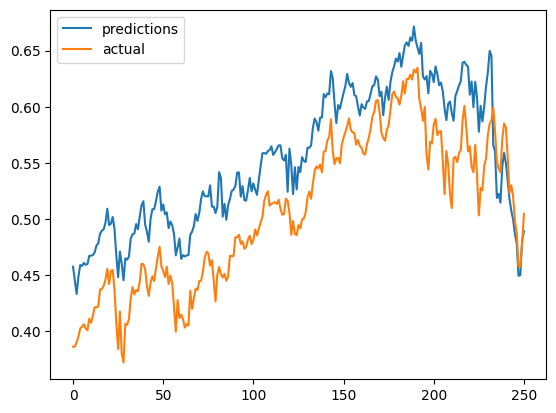

Plotting predictions vs actual for TSLA


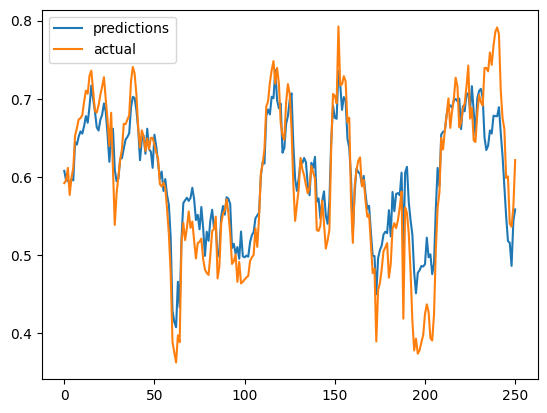

Plotting predictions vs actual for AAPL


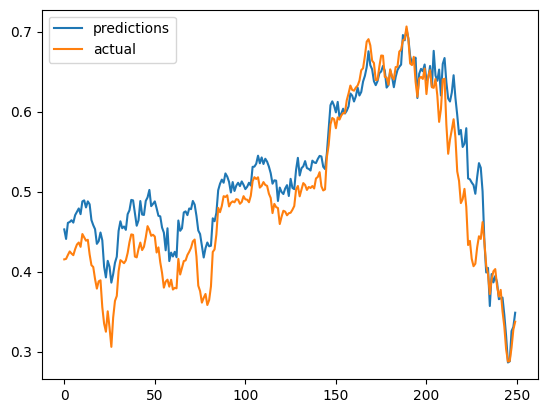

Plotting predictions vs actual for AMZN


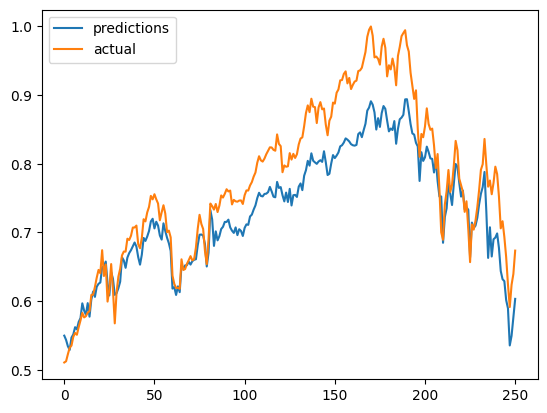

Plotting predictions vs actual for GOOG


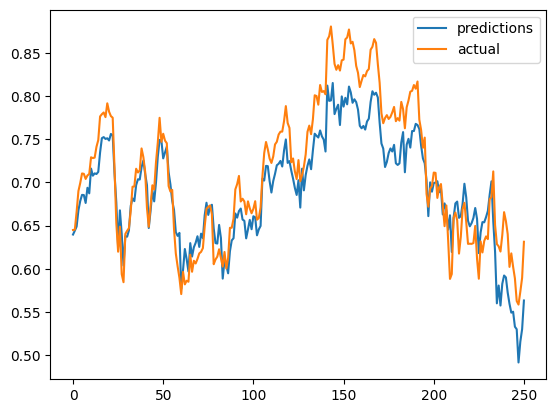

Plotting predictions vs actual for GOOGL


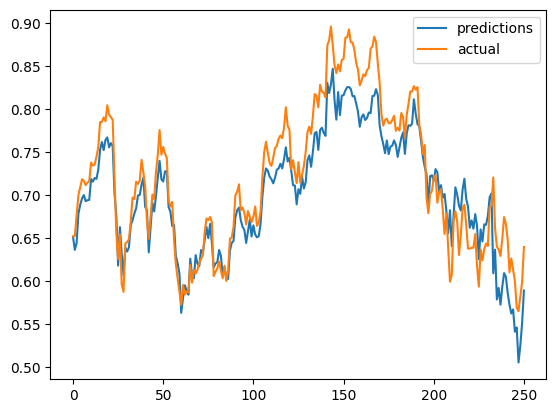

In [ ]:

for i in range(len(test_loader)):
    print(f'Plotting predictions vs actual for {companies[i]}')
    plot_predictions(model, test_loader[i])
    